In [329]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

from itertools import product

In [2]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

In [193]:
n_jobs = 3
n_machines = 3
max_duration = 2
timespan = 6

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

In [129]:
def get_variables(instance):

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    variables = np.zeros((n_machines, n_jobs, instance['timespan']))
    
    return variables


In [130]:
variables = get_variables(instance)
variables.shape

(3, 3, 6)

In [243]:
graph = nx.Graph()
job_groups = {}

for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

task_groups = {}

m_seq = {}

for job in range(n_jobs):
      m_seq[job] = []
      for task in instance[job]:
            m_seq[job].append(task[0])

for job in m_seq:
      task_groups[job] = []
      
      for m in m_seq[job]:
            tmp = []

            for node in job_groups[job]:
                  if m == node[0]:
                        tmp.append(node)

            task_groups[job].append(tmp)


pos_dict = {}

for n in graph.nodes:
    pos_dict[n] = graph.nodes[n]['pos']

In [305]:
def build_graph(instance):
    graph = nx.Graph()
    job_groups = {}

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

    task_groups = {}

    m_seq = {}

    for job in range(n_jobs):
        m_seq[job] = []
        for task in instance[job]:
                m_seq[job].append(task[0])

    for job in m_seq:
        task_groups[job] = []
        
        for m in m_seq[job]:
                tmp = []

                for node in job_groups[job]:
                    if m == node[0]:
                            tmp.append(node)

                task_groups[job].append(tmp)


    pos_dict = {}

    for n in graph.nodes:
        pos_dict[n] = graph.nodes[n]['pos']


    return graph, task_groups

In [311]:
graph, task_groups = build_graph(instance)

In [312]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

In [155]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in instance:
        if job != 'timespan':
            for i in range(n_machines-1):
                task = instance[job][i]
                m = task[0]
                p = task[1]
                for t in range(timespan):
                    t_max = t + p
                    for t_p in range(t_max-1):
                        task_p = instance[job][i+1]
                        m_p = task_p[0]
                        p_p = task_p[1]

                        edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

In [319]:
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

In [354]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for task in instance[job]:
            if task[0] == m:
                I_m.add((m,job))
    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)

    return I_mx

In [360]:
def A_set(instance, m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_mx = I_set(instance, m)

    A_m = set()

    for e in I_mx:
        job = e[0][1]
        m = e[0][0]
        for t in instance[job]:
            if t[0] == m:
                p = t[1]
        
        for t in range(timespan):
            for t_p in range(timespan):
                if (0<=t_p - t) and (t_p-t<p):
                    new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
                    A_m.add(new_el)
    return A_m
    


In [359]:
i = I_set(instance,0)
i

{((0, 0), (0, 1)),
 ((0, 0), (0, 2)),
 ((0, 1), (0, 0)),
 ((0, 1), (0, 2)),
 ((0, 2), (0, 0)),
 ((0, 2), (0, 1))}

In [342]:
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

In [361]:
i = A_set(instance, 0)
i

{((0, 0, 0), (0, 1, 0)),
 ((0, 0, 0), (0, 1, 1)),
 ((0, 0, 0), (0, 2, 0)),
 ((0, 0, 0), (0, 2, 1)),
 ((0, 0, 1), (0, 1, 1)),
 ((0, 0, 1), (0, 1, 2)),
 ((0, 0, 1), (0, 2, 1)),
 ((0, 0, 1), (0, 2, 2)),
 ((0, 0, 2), (0, 1, 2)),
 ((0, 0, 2), (0, 1, 3)),
 ((0, 0, 2), (0, 2, 2)),
 ((0, 0, 2), (0, 2, 3)),
 ((0, 0, 3), (0, 1, 3)),
 ((0, 0, 3), (0, 1, 4)),
 ((0, 0, 3), (0, 2, 3)),
 ((0, 0, 3), (0, 2, 4)),
 ((0, 0, 4), (0, 1, 4)),
 ((0, 0, 4), (0, 1, 5)),
 ((0, 0, 4), (0, 2, 4)),
 ((0, 0, 4), (0, 2, 5)),
 ((0, 0, 5), (0, 1, 5)),
 ((0, 0, 5), (0, 2, 5)),
 ((0, 1, 0), (0, 0, 0)),
 ((0, 1, 0), (0, 2, 0)),
 ((0, 1, 1), (0, 0, 1)),
 ((0, 1, 1), (0, 2, 1)),
 ((0, 1, 2), (0, 0, 2)),
 ((0, 1, 2), (0, 2, 2)),
 ((0, 1, 3), (0, 0, 3)),
 ((0, 1, 3), (0, 2, 3)),
 ((0, 1, 4), (0, 0, 4)),
 ((0, 1, 4), (0, 2, 4)),
 ((0, 1, 5), (0, 0, 5)),
 ((0, 1, 5), (0, 2, 5)),
 ((0, 2, 0), (0, 0, 0)),
 ((0, 2, 0), (0, 1, 0)),
 ((0, 2, 1), (0, 0, 1)),
 ((0, 2, 1), (0, 1, 1)),
 ((0, 2, 2), (0, 0, 2)),
 ((0, 2, 2), (0, 1, 2)),


In [339]:
a = (1,2,3)
a.append(4)

AttributeError: 'tuple' object has no attribute 'append'

In [314]:
soo_curved, soo_straight = soo_edges(instance)

In [157]:
oo_straight = oo_edges(instance)

114

In [315]:
graph.add_edges_from(soo_curved)
graph.add_edges_from(soo_straight)

In [244]:
graph.add_edges_from(oo_straight)

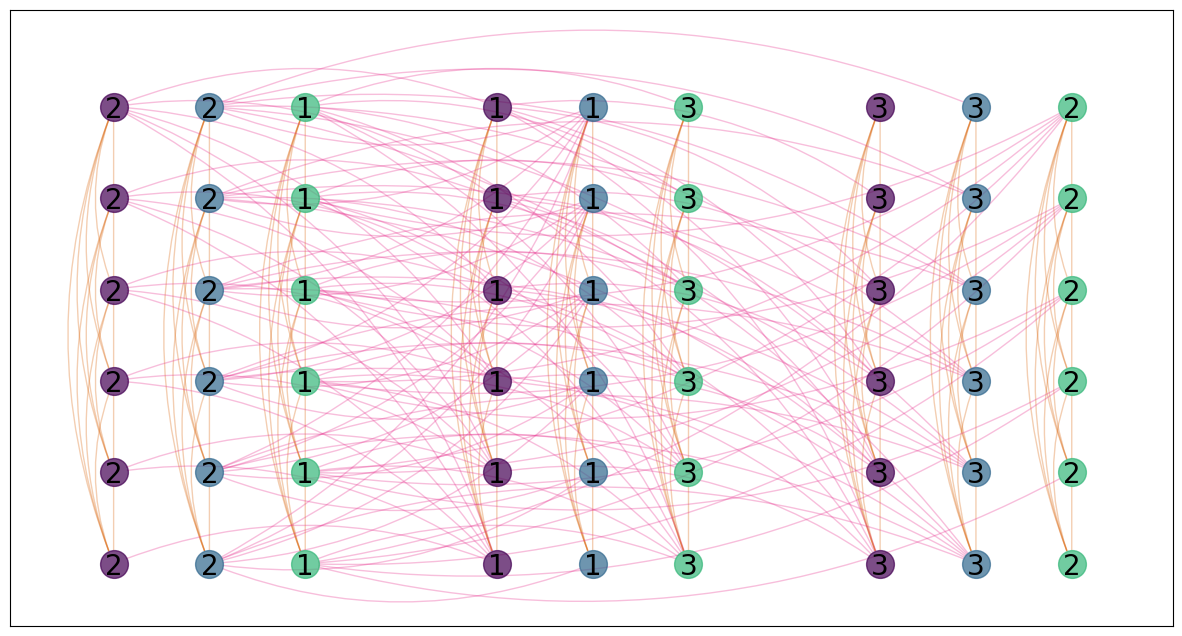

In [318]:
plt.figure(figsize=(15,8))
cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
cmap_edges = matplotlib.colormaps.get_cmap('Dark2')
node_size = 400
node_alpha = 0.7
edge_alpha = 0.3


for job in task_groups:
    for i,task in enumerate(task_groups[job]):
        nx.draw_networkx_nodes(graph, pos_dict, node_size=node_size, nodelist=task, node_color=cmap_nodes(job/len(task_groups)), alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict, labels, font_size=20, verticalalignment='center_baseline')
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_curved, arrows=True, connectionstyle="arc3,rad=0.2", alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=soo_straight, arrows=True, connectionstyle="arc3", alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph, pos_dict, node_size=node_size, edgelist=oo_straight, arrows=True, connectionstyle="arc3,rad=0.2", alpha=edge_alpha, edge_color=cmap_edges(0.4))


plt.show()